## Justificación del enfoque `t-F2F`

El benchmark ADORE propone diversos retos para evaluar la capacidad predictiva de modelos de toxicidad en organismos acuáticos. Este proyecto se centra en el *Challenge 2*, cuyo objetivo es predecir la toxicidad aguda de compuestos químicos **dentro del mismo grupo taxonómico**.

Para ello se emplea el dataset `t-F2F_mortality.csv`, que representa la tarea `Fish-to-Fish` con el prefijo `t-` indicando que el conjunto de datos está **restringido a un grupo taxonómico específico**, en este caso, los peces. 

Esta estrategia permite entrenar y evaluar modelos de forma más robusta, evitando sesgos derivados de mezclar organismos con fisiologías o exposiciones muy distintas (como algas y crustáceos), y asegurando mayor validez ecológica y regulatoria.

#  BLOQUE 1 – Carga y exploración de datos

Según la documentación oficial del benchmark ADORE, los datos han sido preprocesados, curados y estandarizados para asegurar su calidad.
No obstante, se incluyen valores ausentes en algunas columnas, ya que el dataset también está diseñado para facilitar otras líneas de investigación futuras no abordadas en los retos definidos.

Por tanto, no es necesario realizar un proceso de limpieza clásico. Aun así, se realiza una inspección inicial de tipos y valores para asegurar consistencia interna.

In [1]:
# Librerías
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns

from collections import Counter
from collections import defaultdict

In [2]:
# Ruta local al archivo
file_path = '../../data/raw/t-F2F_mortality.csv'

# Cargar el dataset
df = pd.read_csv(file_path, low_memory= False)

# Primer vistazo
df.head()

,test_id,reference_number,test_cas,test_location,test_exposure_type,test_control_type,test_media_type,test_application_freq_unit,test_organism_lifestage,result_id,...,split_random,split_occurrence,split_scaffold-murcko,split_scaffold-murcko-loo-0,split_scaffold-murcko-loo-1,split_scaffold-murcko-llo,split_scaffold-generic,split_scaffold-generic-loo-0,split_scaffold-generic-loo-1,split_scaffold-generic-llo
0,1000130,35,2039-46-5,LAB,NR,I,FW,NR,NR,124331,...,3,test,4,test,trainvalid,trainvalid,4,test,trainvalid,trainvalid
1,1001265,182,94-09-7,LAB,S,I,FW,X,NR,112643,...,3,2,4,test,trainvalid,trainvalid,4,test,trainvalid,trainvalid
2,1001266,182,94-09-7,LAB,S,I,FW,X,NR,112644,...,3,2,4,test,trainvalid,trainvalid,4,test,trainvalid,trainvalid
3,1001636,219,151-21-3,LAB,NR,I,FW,NR,NR,131358,...,4,test,3,trainvalid,test,trainvalid,3,trainvalid,test,trainvalid
4,1001694,225,52918-63-5,LAB,S,I,FW,X,NR,111395,...,3,2,2,trainvalid,trainvalid,trainvalid,2,trainvalid,trainvalid,trainvalid


In [3]:
# Información general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26114 entries, 0 to 26113
Columns: 1106 entries, test_id to split_scaffold-generic-llo
dtypes: bool(3), float64(742), int64(308), object(53)
memory usage: 219.8+ MB


In [4]:
# Dimensión
print(f"El dataset tiene {df.shape[0]:,} filas y {df.shape[1]} columnas")

El dataset tiene 26,114 filas y 1106 columnas


In [5]:
# Nulos y duplicados
print("valores nulos:", df.isnull().sum().sum())
print("Duplicados:", df.duplicated().sum())

valores nulos: 74740
Duplicados: 0


# Train/test split (según benchmark ADORE)

El benchmark ADORE propone una estrategia de partición basada en la **ocurrencia química**, es decir, asegura que un mismo compuesto no aparece en ambos conjuntos (train y test). Esto evita fugas de información y garantiza que la evaluación del modelo refleje su verdadera capacidad de generalización frente a compuestos nuevos y estructuralmente distintos.

Para ello, ADORE proporciona un split predefinido en la columna `split_occurrence`:

- Grupos `0` a `4`: conforman el conjunto de entrenamiento + validación (`trainval`)
- Grupo `"test"`: reservado como conjunto de evaluación final (`test`)

Además, los grupos `0–4` están pensados para facilitar **validación cruzada estratificada**, como parte del Challenge 2.

In [6]:
# Visualización del split
df['split_occurrence'].value_counts()
df['split_occurrence'].value_counts(normalize=True)

split_occurrence
0       0.177568
1       0.170445
2       0.167113
3       0.164356
4       0.162250
test    0.158268
Name: proportion, dtype: float64

In [7]:
# División según los grupos definidos por el benchmark
df_test = df[df['split_occurrence'] == 'test'].copy()
df_trainval = df[df['split_occurrence'].isin(['0', '1', '2', '3', '4'])].copy()

print(f"Tamaño conjunto train+val: {df_trainval.shape}")
print(f"Tamaño conjunto test: {df_test.shape}")

Tamaño conjunto train+val: (21981, 1106)
Tamaño conjunto test: (4133, 1106)


A partir de este punto:

- Todos los análisis (EDA, transformaciones, modelado) se realizarán **solo sobre `df_trainval`**
- El conjunto `df_test` se mantendrá **intacto** hasta la evaluación final, siguiendo las recomendaciones del benchmark ADORE.

# Identificación del target

### Exploración y agrupación funcional de columnas

Para facilitar la navegación por un dataset tan extenso, se realiza una agrupación funcional de columnas basada en sus prefijos. Esta categorización preliminar permite reducir la complejidad, entender mejor su estructura.

In [8]:
# Conteo por tipo de dato
df_trainval.dtypes.value_counts()

float64    742
int64      308
object      53
bool         3
Name: count, dtype: int64

In [9]:
# Ver muestra de nombres de columnas
columns = df.columns.tolist()
columns[:100]

['test_id',
 'reference_number',
 'test_cas',
 'test_location',
 'test_exposure_type',
 'test_control_type',
 'test_media_type',
 'test_application_freq_unit',
 'test_organism_lifestage',
 'result_id',
 'result_effect',
 'result_endpoint',
 'result_obs_duration_mean',
 'result_conc1_type',
 'result_conc1_mean_op',
 'result_conc1_mean',
 'result_conc1_mean_mol',
 'media_ph_mean',
 'media_temperature_mean',
 'tax_all',
 'tax_name',
 'tax_class',
 'tax_order',
 'tax_family',
 'tax_genus',
 'tax_species',
 'tax_gs',
 'species_number',
 'tax_group',
 'tax_pdm_available',
 'tax_eco_climate',
 'tax_eco_ecozone',
 'tax_eco_food',
 'tax_eco_migrate5',
 'tax_eco_migrate2',
 'tax_ps_ampv',
 'tax_ps_ampkap',
 'tax_ps_amppm',
 'tax_lh_amd',
 'tax_lh_lbcm',
 'tax_lh_lpcm',
 'tax_lh_licm',
 'tax_lh_ri#/d',
 'result_conc1_mean_binary',
 'result_conc1_mean_log',
 'result_conc1_mean_mol_log',
 'chem_dtxsid',
 'chem_name',
 'test_cas_name',
 'chem_sf',
 'chem_mw',
 'chem_mp',
 'chem_ws',
 'chem_ws_binary

In [10]:
# Cuántas columnas empiezan por cada prefijo?
prefijos = [col.split('_')[0] for col in columns]
Counter(prefijos).most_common()

[('chem', 1048),
 ('tax', 23),
 ('result', 11),
 ('split', 11),
 ('test', 9),
 ('media', 2),
 ('reference', 1),
 ('species', 1)]

In [11]:
# Agrupación de nombres de columnas por su prefijo
grouped_cols = defaultdict(list)

for col in df_trainval.columns:
    prefijo = col.split('_')[0]
    grouped_cols[prefijo].append(col)

# Mostrar un resumen del contenido por grupo
for group, cols in grouped_cols.items():
    print(f"\n {group.upper()}_ → {len(cols)} columnas")
    print(", ".join(cols[:8]) + ("..." if len(cols) > 8 else ""))


 TEST_ → 9 columnas
test_id, test_cas, test_location, test_exposure_type, test_control_type, test_media_type, test_application_freq_unit, test_organism_lifestage...

 REFERENCE_ → 1 columnas
reference_number

 RESULT_ → 11 columnas
result_id, result_effect, result_endpoint, result_obs_duration_mean, result_conc1_type, result_conc1_mean_op, result_conc1_mean, result_conc1_mean_mol...

 MEDIA_ → 2 columnas
media_ph_mean, media_temperature_mean

 TAX_ → 23 columnas
tax_all, tax_name, tax_class, tax_order, tax_family, tax_genus, tax_species, tax_gs...

 SPECIES_ → 1 columnas
species_number

 CHEM_ → 1048 columnas
chem_dtxsid, chem_name, chem_sf, chem_mw, chem_mp, chem_ws, chem_ws_binary, chem_dtxcid...

 SPLIT_ → 11 columnas
split_totallyrandom, split_random, split_occurrence, split_scaffold-murcko, split_scaffold-murcko-loo-0, split_scaffold-murcko-loo-1, split_scaffold-murcko-llo, split_scaffold-generic...


| Prefijo   | Significado general (según paper)                                                                    |
| --------- | ---------------------------------------------------------------------------------------------------- |
| `chem_`   | Descriptores químicos de la sustancia, incluyendo propiedades moleculares, fingerprints, SMILES y mol2vec. Incluye también categorías químicas y clasificaciones          |
| `tax_`    | Información taxonómica del organismo expuesto (familia, género, especie, taxonomic group, etc.), que permite distinguir entre diferentes niveles taxonómicos              |
| `test_`   | Condiciones del experimento, como tipo de exposición (static, flow-through, renewal), duración, frecuencia de aplicación, tipo de medio, etc                              |
| `result_` | Resultados de toxicidad, incluyendo valores numéricos como EC50 o LC50, unidades, efectos observados, endpoints medicados, etc.                                           |
| `media_`  | Condiciones físicas y químicas del medio de prueba tales como temperatura, pH, tipo de agua (agua dulce o salada), concentración media, etc.                              |
| `split_`  | Variables relacionadas con la estrategia de partición de datos en conjuntos de entrenamiento y prueba, incluyendo los grupos 0-4 y test, para evaluación del modelo       |

## Elección del target

La variable objetivo (`target`) representa la toxicidad medida en cada experimento, y puede adoptar diferentes formas dentro del dataset. A continuación se describen las principales:

1. `result_conc1_mean_log`
- Es el **logaritmo base 10** de la variable anterior.
- Se utiliza para estabilizar la varianza y reducir la escala de los valores (algunos rangos varían en varios órdenes de magnitud).

2. `result_conc1_mean_mol_log`
- Es la versión logarítmica en **unidades molares**.
- Puede ser útil cuando se pretende modelar la toxicidad desde un punto de vista molecular o farmacológico.
3. `result_conc1_mean_binary`
- Es una variable categórica binaria derivada de `result_conc1_mean_log` o su equivalente.
- Clasifica cada observación como:
    - 0 → sustancia menos tóxica
    - 1 → sustancia más tóxica
- Aunque el umbral exacto no está documentado explícitamente, probablemente corresponde a un valor de corte basado en criterios regulatorios (por ejemplo, log(LC50) ≈ –0.3).
- Esta variable está alineada con el enfoque de clasificación binaria propuesto en el Challenge 2 del benchmark ADORE.


### Otras variables relevantes del dataset

- **Descriptores químicos**: fingerprints, descriptores moleculares, propiedades físico-químicas.
- **Información del organismo**: especie, clase taxonómica, tasa reproductiva, tamaño.
- **Condiciones experimentales**: tipo de medio, duración, endpoint toxicológico.
- **Metadatos e identificadores**: códigos químicos (`CAS`), nombres comunes, IDs internos.

### Target

- Las variables `result_conc1_mean*` son medidas **intrínsecas de toxicidad**, por lo tanto **son candidatas naturales como objetivo de un modelo de regresión**.
- En paralelo, existe una variable derivada `result_conc1_mean_binary`, que clasifica las observaciones como más o menos tóxicas, posiblemente en base a un umbral (e.g., log(LC50) ≈ -0.3).
  - Esta variable puede ser empleada como objetivo en un modelo de **clasificación binaria**, como el propuesto en el Challenge 2 del benchmark ADORE.

In [12]:
df_trainval["result_conc1_mean_binary"].value_counts()
df_trainval.groupby("result_conc1_mean_binary")["result_conc1_mean_log"].describe()

,count,mean,std,min,25%,50%,75%,max
result_conc1_mean_binary,,,,,,,,
0,12962.0,1.215135,0.870121,0.002166,0.544068,1.078093,1.661126,4.977724
1,9019.0,-1.238051,0.898506,-5.698970,-1.853872,-1.080922,-0.502380,0.000000


Su distribución es aproximadamente 58 % / 42 %, lo que sugiere un cierto desbalance, pero no extremo.

Al analizar su relación con `result_conc1_mean_log`, se observa que las sustancias marcadas como `1` (más tóxicas) tienen valores medios notablemente más bajos en log10(mg/L), lo que **confirma su sentido ecotoxicológico**.

Aunque el umbral de corte no está documentado explícitamente, todo indica que se ha aplicado una transformación coherente con los criterios estándar en toxicología.

> Esta variable se considera **una candidata válida como target binario** para el caso de clasificación, y será evaluada más adelante.

In [13]:
# Nombre de la variable objetivo
target = "result_conc1_mean_binary"

# Separación
X_train = df_trainval.drop(columns=target).copy()
y_train = df_trainval[target].copy()

In [14]:
# Validación básica
print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de y_train: {y_train.shape}")
print(f"Distribución del target:\n{y_train.value_counts(normalize=True)}")

Shape de X_train: (21981, 1105)
Shape de y_train: (21981,)
Distribución del target:
result_conc1_mean_binary
0    0.589691
1    0.410309
Name: proportion, dtype: float64


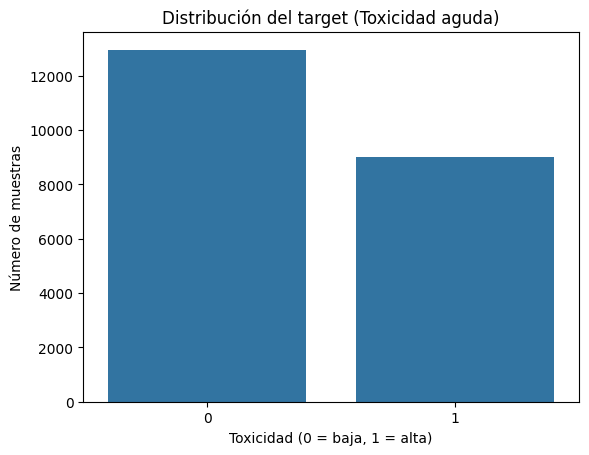

In [15]:
# Visualización de frecuencias
sns.countplot(x=df_trainval[target])
plt.title("Distribución del target (Toxicidad aguda)")
plt.xlabel("Toxicidad (0 = baja, 1 = alta)")
plt.ylabel("Número de muestras")
plt.show()

C:\Users\javie\AppData\Local\Temp\ipykernel_27432\3288394185.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=conteo.index, y=conteo.values, palette=colores_space)


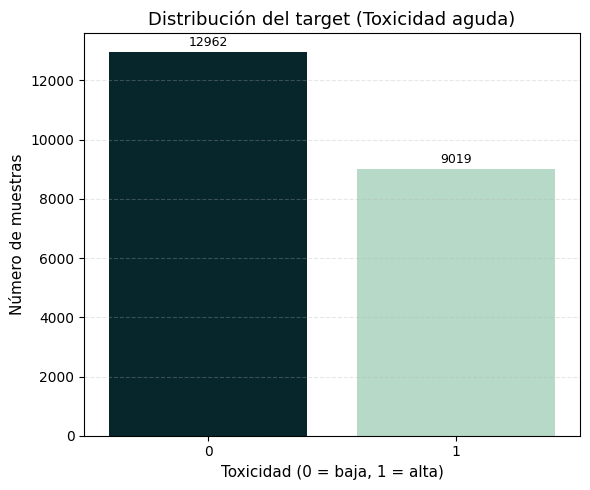

In [22]:
# Gráfico Presentación
# Definir serie y colores
serie = df_trainval[target]
colores_space = ['#002A32', '#B0E0C6']  # azul marino y verde menta

# Calcular recuento
conteo = serie.value_counts().sort_index()

# Crear figura
plt.figure(figsize=(6, 5))
ax = sns.barplot(x=conteo.index, y=conteo.values, palette=colores_space)

# Etiquetas numéricas más pequeñas, sin negrita, con margen superior
for i, valor in enumerate(conteo.values):
    ax.text(i, valor + 100, str(valor), ha='center', va='bottom',
            fontsize=9)  

# Estilo general
plt.title("Distribución del target (Toxicidad aguda)", fontsize=13)
plt.xlabel("Toxicidad (0 = baja, 1 = alta)", fontsize=11)
plt.ylabel("Número de muestras", fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()